We're modeling data with a distribution of the form $y=ax+b+\epsilon$, where the $\epsilon$ is noise from a distribution which depends on $x$, as well global parameters. The primary goal is derive a good estimate for $a$ and $b$.

We will try to model $\epsilon=y-ax+b$ using a student t distribution (we may assume the mode is zero), where both the shape and the scale will be allowed to depend on $x$. To find the parameters, we will try to minimize the cross-entropy between our modeling distribution and the empirical data; this minimization will be accomplished using gradient descent (implemented in the TensorFlow library www.tensorflow.org).

We will use $l2$ regularization to prevent overfitting, and chose the regularization strength by bayesian optimization of the cross-validation error. To this end, we shuffle and divide the data we are given into three groups: 60% training, 20% validation, 20% testing.

In [1]:
import tensorflow as tf
import tensorflow.contrib.distributions as dist
import numpy as np
import pandas as pd
from numpy import pi
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import FloatProgress
from IPython.display import display

testing_proportion = 0.2
validation_proportion = 0.2

hyper_param_dim=6
l2_reg_min,l2_reg_max = -50,0
sqrt_2 = np.sqrt(2.).astype(np.float32)
sqrt_5 = np.sqrt(5.).astype(np.float32)
# The folowing are global settings used for the bayesian optimization of the hyper-parameters.
initial_GP_test_points = 5 # these are randomly chosen points with which to initialize the bayesian optimization
total_GP_test_points = 20 # total number of points used in bayesian optimization
max_feelers = 10 # number of points used in batch-gradient-descent optimization.

Let's import and plot the data to have a look at it:

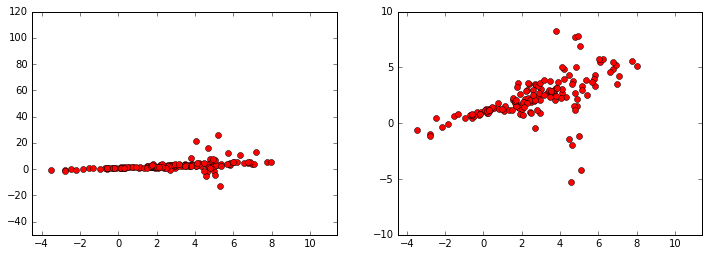

In [2]:
# First, we import and shuffle the data.
data = pd.read_csv("data.csv").as_matrix()
x_min,x_max = np.min(data[:,0])-1,np.max(data[:,0])+1
y_min,y_max = np.min(data[:,1])-1,np.max(data[:,1])+1
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_ylim(-50,120)
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(-10,10)
ax1.plot(data[:,0],data[:,1],'ro')
ax2.plot(data[:,0],data[:,1],'ro')
plt.show()

We shuffle and separate out the testing data right now...

In [3]:
# First, we shuffle the data.
data = np.random.permutation(data)
data_len,_ = data.shape
# Next we divide the data into (training and validation) vs testing sets
test_data_len = int(np.floor(data_len*testing_proportion))
valid_data_len = int(np.floor(data_len*validation_proportion))
# the testing set gets a data slice of size test_data_len
test_data = data[:test_data_len,:] 
# the train/validation set gets the rest
train_and_valid_data=data[test_data_len:,:]

Now we write a helper function which shuffles the train_and_valid_data set and splits it into a training and validation set. This will be helpful later when choosing hyperparemeters via cross validation.

In [4]:
def train_and_valid_set_split():
    shuffled_train_and_valid_data = np.random.permutation(train_and_valid_data)
    # the validation set gets the next data slice of size valid_data_len
    valid_data = shuffled_train_and_valid_data[:valid_data_len,:]
    # the training data is whatever's left.
    train_data = shuffled_train_and_valid_data[valid_data_len:,:]
    return train_data,valid_data

Now we create placeholders for the input data, the target data of our model, and the regularization strength hyper-parameters.

In [5]:
# Create a placeholder for the input data
x = tf.placeholder(tf.float32, shape = [None]) # here shape=[None] refers to a variable length vector
# Create a placeholder for the target data
y_ = tf.placeholder(tf.float32, shape = [None]) # here shape=[None] refers to a variable length vector
# Create a placeholder for the hyper-paremeters
l2_reg_strength = tf.placeholder(tf.float32,shape = [hyper_param_dim]) # here shape=2 refers to vector of length 2.

The mode of $\epsilon$ should be $y=ax+b$. We want to learn the values of $a$ and $b$, so let's define variables for them (which are initialized to zero).

In [6]:
with tf.variable_scope('model'):
    a = tf.Variable(initial_value = tf.constant(0.),name = "slope_of_mode")
    b = tf.Variable(initial_value = tf.constant(0.),name = "x_intercept_of_mode")
    y = a*x+b

We're going to model the noise via a student t distribution,
$$\frac{\Gamma(\frac{\nu+1}{2})}{\sigma \sqrt{\nu \pi}\Gamma(\frac{\nu}{2})}\left[\frac{\nu+(\frac{y-\mu}{\sigma})^2}{\nu}\right]^{-\frac{\nu+1}{2}}$$
whose parameters are: mode $\mu$, scale $\sigma>0$, shape $\nu>0$.

We want to let the shape and scale vary with $x$. Looking at the plot of the data, we notice that the data points seem to focus near $x=0$, and spread as $x$ grows; to try to capture this phenomenon, we choose a simple functional form for the scale of the distribution (as a function of $x$):
$$\sigma=w_{bias}((\frac{w_{slope}}{w_{bias}}x-w_{arg-min})^2+1)^{w_{pow}}$$
For simplicity, we are assuming that $\sigma(x)$ is symmetric about $x=w_{arg-min}$. The value of $\sigma(x)$ at $x=w_{arg-min}$ is $w_{bias}$. When $w_{pow}=1/2$, then $w_{slope}$ is the asymptotic rate of change of the scale $\sigma(x)$, and the functional form of $\sigma(x)$ is what we would expect from a bayesian treatment linear gaussian regression (which results in a t-distribution, after integrating over the posterior); such a functional form for $\sigma(x)$ allows us to incorporate some uncertainty in the value of $b$ directly into the model. Here, we vary this slightly, allowing the precise value of $w_{pow}$ to be learnt.

We give the shape $\nu$ a similar functional form.

In [7]:
with tf.variable_scope('model'):
    log_bias_scale = tf.Variable(tf.constant(0.),name="scale_log_bias")
    arg_min_scale = tf.Variable(tf.constant(0,tf.float32),name="scale_arg_min")
    slope_scale = tf.Variable(tf.constant(1.),name="scale_log_slope")
    pow_scale = tf.Variable(tf.constant(.5,name='power_for_scale'))
    scale = tf.pow(tf.square(slope_scale*(x-arg_min_scale))/tf.exp(log_bias_scale)+1.,
                   pow_scale, name="scale")*tf.exp(log_bias_scale)

    log_bias_shape = tf.Variable(tf.constant(0.),name="shape_log_bias")
    arg_min_shape = tf.Variable(tf.constant(0,tf.float32),name="shape_arg_min")
    slope_shape = tf.Variable(tf.constant(1.),name="shape_log_slope")
    pow_shape = tf.Variable(tf.constant(-.5,name='power_for_shape'))
    shape = tf.pow(tf.square(slope_shape*(x-arg_min_shape))/tf.exp(log_bias_shape)+1.,
                   pow_shape,name="shape")*tf.exp(log_bias_shape)

Now let's plug these variables into the student t distribution.

In [8]:
model_distribution = dist.StudentT(df = shape, mu = y, sigma = scale)

We will try to minimize the cross-entropy between the empirical data and the modeled distribution. Explicitly, we are interested in minimizing $H(p,q)=-\int p(y\mid x)\log(q(y\mid x,\mathrm{parameters}))$, where $p$ denote the actual distribution and $q(x|\mathrm{parameters})$ denote the model we are trying to fit; the minimization is done over the space of parameters. We estimate $H(p,q)$ as:
$$-\sum_{i=1}^N\frac{1}{N}\log(q(y_i\mid x_i,\mathrm{parameters})).$$
We accomplish the minimization using (Adam) gradient descent, and we incorporate l2-regularization: Our prior beliefs are encoded as normal distributions for each of the scale and shape hyperparameters:
The prior means are chosen so that the scale $\sigma$ is predisposed to be constant or to have assymptotically linear growth (with a minimum near zero), while the shape $\nu$ is predisposed to be constant or to drop off assymptotically as $1/x$ (with a maximum near zero).

Our confidence in these prior beliefs (i.e. the variance of the normal distributions modeling our priors) will be learnt using bayesian optimization of the cross-entropy error measured on the validation set.

In [9]:
# We compute a vector of log-likelihoods
log_likelihoods = model_distribution.log_pdf(y_)
# the cross_entropy is the mean of the log_likelihoods
cross_entropy = -tf.reduce_mean(log_likelihoods)
# we optimize via (Adam) gradient descent
with tf.variable_scope('training_model'):
    model_lr = tf.placeholder(tf.float32)
    optimizer = tf.train.AdamOptimizer(model_lr)
    # the gradient descent objective incorporates our priors via L2 regularization to compute the MAP
    train = optimizer.minimize(cross_entropy
                           +tf.reduce_sum(tf.mul(l2_reg_strength,tf.pack(
                [tf.nn.l2_loss(slope_scale),tf.nn.l2_loss(pow_scale-.5),
                 tf.nn.l2_loss(slope_shape),tf.nn.l2_loss(pow_shape+.5),
                 tf.nn.l2_loss(arg_min_scale),tf.nn.l2_loss(arg_min_shape)]))))

Now we write some code to compute the MAP estimate for our parameters. It starts by splitting the data into training and cross validation sets, then it runs gradient descent on the training set to get a MAP estimate, and returns the cross-entropy estimated via the validation set.

Note that we randomly split the non-testing data into training and validation sets; we are implicitly bootstrapping in order to estimate the mean and variance of the cross-entropy error as measured on the validation set.

In [10]:
def train_model(l2_reg_strength_val,num_steps=1000,verbose=False,learning_rate=0.05):
    # First we initialize the variables in the model and the training optimizer:
    model_variables = tf.get_collection(tf.GraphKeys.VARIABLES, scope='model')
    tf.initialize_variables(model_variables).run()
    training_variables = tf.get_collection(tf.GraphKeys.VARIABLES, scope='training_model')
    tf.initialize_variables(training_variables).run()
    # Next we split the training/validation data:
    train_data,valid_data = train_and_valid_set_split()
    for step in range(num_steps+1):
        training_loss,_ = sess.run([cross_entropy,train],
                                   {x:train_data[:,0],
                                    y_:train_data[:,1],
                                    l2_reg_strength:l2_reg_strength_val,
                                   model_lr:learning_rate})
        if verbose and step % 100 == 0:
            print("step: %d, loss: %.3f, a: %.4f, b: %.4f, min scale: %.4f, scale rate of change: %.4f, \n \
                     min shape: %.4f shape rate of change: %.2f"
                  %(step,training_loss, a.eval(), b.eval(),
                    tf.exp(log_bias_scale).eval(),tf.abs(slope_scale).eval(),
                    tf.exp(log_bias_shape).eval(),tf.abs(slope_shape).eval()))
        
    return cross_entropy.eval({x:valid_data[:,0],y_:valid_data[:,1]})

Let's also introduce a helper function to plot the resulting model. The line $y=ax+b$ will be plotted in blue, the probability density in green, and we will plot the standard deviation in purple (where defined, i.e. when $\nu>2$).

In [11]:
def plot_model(ylim=None):
    x_step_size=(x_max-x_min)/20.
    y_step_size=(y_max-y_min)/20.
    x_grid = np.arange(x_min,x_max,x_step_size)
    y_grid = np.arange(y_min,y_max,y_step_size)
    fig, ax = plt.subplots()
    
    # Plot the predicted probability density
    X,Y = np.meshgrid(x_grid, y_grid)
    Z = np.exp(log_likelihoods.eval({x:X.reshape(-1),y_:Y.reshape(-1)})).reshape(len(x_grid),len(y_grid))
    ax.contourf(X,Y,Z,cmap='YlGn')
    ax.autoscale(False)
    
    # plot the predicted mode
    ax.plot(x_grid,a.eval()*x_grid+b.eval(),linewidth=2)
    
    # plot the standard deviation
    # first, restrict to where it's defined
    x_std_dev_defined = x_grid[shape.eval({x:x_grid})>2]
    # then compute the standard deviation
    std_dev = (scale*tf.sqrt((shape/(shape-2.)))).eval({x:x_std_dev_defined})
    # now plot it
    ax.plot(x_std_dev_defined,a.eval()*x_std_dev_defined+b.eval()+std_dev,'purple')
    ax.plot(x_std_dev_defined,a.eval()*x_std_dev_defined+b.eval()-std_dev,'purple')
    
    #plot the data
    ax.plot(data[:,0],data[:,1],'ro')
    if ylim is not None:
        ax.set_ylim(ylim)
    plt.show()

Ok, let's start a TensorFlow session, and test the training algorithm:

step: 0, loss: 3.416, a: 0.0500, b: 0.0500, min scale: 0.9512, scale rate of change: 0.9500, 
                      min shape: 1.0513 shape rate of change: 0.95
step: 100, loss: 1.671, a: 0.5399, b: 0.9913, min scale: 0.0876, scale rate of change: 0.5165, 
                      min shape: 2.5166 shape rate of change: 0.68
step: 200, loss: 1.654, a: 0.5275, b: 1.0062, min scale: 0.1017, scale rate of change: 0.7333, 
                      min shape: 4.7206 shape rate of change: 0.99
step: 300, loss: 1.647, a: 0.5253, b: 1.0097, min scale: 0.0948, scale rate of change: 1.0337, 
                      min shape: 7.3301 shape rate of change: 1.27
step: 400, loss: 1.644, a: 0.5247, b: 1.0116, min scale: 0.0865, scale rate of change: 1.3170, 
                      min shape: 9.9128 shape rate of change: 1.55
step: 500, loss: 1.643, a: 0.5244, b: 1.0130, min scale: 0.0800, scale rate of change: 1.5558, 
                      min shape: 12.3067 shape rate of change: 1.82
step: 600, loss: 1.642,

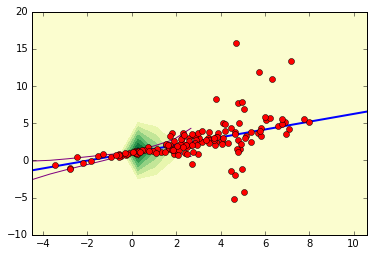

In [12]:
sess = tf.InteractiveSession()
print("-"*30+"\n validation-cross-entropy estimate: %f"
      %train_model(l2_reg_strength_val = [0.0,0.0,0.0,0.0,0.0,0.0],num_steps=1000,verbose=True))
plot_model(ylim=[-10,20])

Gradient descent seems to have converged enough after about 500 steps to give a reasonable estimate of the validation-cross-entropy estimate.

Now we need to estimate the hyper-parameters by minimizing the validation-cross-entropy estimate. There are several ways to do this:
1. We could do a grid search over hyper parameters.
2. We could do a random search over hyper parameters.
3. We could numerically optimize the validation-cross-entropy (say via Nelder-Mead)
4. We could do Bayesian optimization.

We'll use a simplified version of the Bayesian optimization procedure outlined in https://arxiv.org/pdf/1206.2944.pdf.

More specifically, we'll model the validation-cross-entropy as a Gaussian Process (of the hyper-parameters).

To model the gaussian process we introduce a helper function to compute the mean (we will ignore the varience to keep things simple): given a kernel $k(x,x')$, and sampled points $\{x_i\}$ with sampled values $\{y_i\}$, the mean is 
$$\mu(x):=k(x,x_i)k_{ij}^{-1}y_j,$$
where the matrix $k_{ij}$ has entries $k_{ij}=k(x_i,x_j)$.

In [13]:
# new_points is assumed to be a list of points
def GP_mean(kernel,GP_sampled_x,GP_sampled_y,new_points):
    # First compute the sample mean:
    sampled_mean_y=tf.reduce_mean(GP_sampled_y,0)
    
    inv_cov_matrix = tf.matrix_inverse(kernel(GP_sampled_x,GP_sampled_x))
    # reshape the the sample values into matrices:
    GP_sampled_y_reshaped = tf.reshape(GP_sampled_y,[-1,1])
    # return the expected mean
    return sampled_mean_y + tf.matmul(kernel(new_points,GP_sampled_x),
                             tf.matmul(inv_cov_matrix,GP_sampled_y_reshaped-sampled_mean_y))

We introduce a second helper function to compute the covariance,
specifically, the covariance matrix is
$$\Sigma(x):=k(x,x)-k(x,x_i)k_{ij}^{-1}k(x_j,x)$$


In [14]:
def GP_cov(kernel,GP_sampled_x,new_points):
    inv_cov_matrix = tf.matrix_inverse(kernel(GP_sampled_x,GP_sampled_x))
    k=kernel(GP_sampled_x,new_points)
    return kernel(new_points,new_points)-tf.matmul(tf.transpose(k),tf.matmul(inv_cov_matrix,k))

We are modeling the validation-cross-entropy error as a gaussian process.
If $\epsilon_{min}$ is the current minimum sampled value of the validation-cross-entropy error, then if we sample at a new point $x_{new}$, we expect to decrease the sampled value of the validation-cross-entropy by
$$\epsilon_{min}-\mu(x_{new}).$$

The **expected improvement** function is definde as $$a_{EI}(x_{new})=\mathbb{E}[\operatorname{max}(\epsilon_{min}-\mu(x_{new}),0)],$$
and we will want to sample at points $x_{new}$ which maximize it. The follow code for the function ```GP_expected_improv``` computes the expected improvement, given the current Gaussian process model for the cross-entropy error (measured on the validation set). 

In [15]:
# new_points is a (num_points,amb_dim) shape matrix of prospective points at which to
# measure the cross-entropy (on the validation set)

def GP_expected_improv(kernel,GP_sampled_x,GP_sampled_y,new_points):
    # compute the mean of the gaussian process at new_points
    mu = tf.reshape(GP_mean(kernel,GP_sampled_x,GP_sampled_y,new_points),[-1])
    # compute the standard deviation across those new_points
    sigma = tf.diag_part(GP_cov(kernel,GP_sampled_x,new_points))
    # check that the standard deviation is positive (and fill in a dummy value of 1 otherwise)
    non_zero_variance = tf.greater(sigma, 0., name="variance_Control_Op")
    sigma_safe = tf.select(non_zero_variance,sigma,tf.tile(tf.constant([1.]),tf.shape(sigma)))
    # model our expected cross-entropy at those new points using the gaussian process
    normal_distribution = dist.Normal(mu = mu,sigma = sigma_safe)
    # compare our model with the current minimum
    min_sampled_y = tf.reshape(tf.reduce_min(GP_sampled_y),[-1])
    # compute the expected value of max(min_sampled_y - mu)
    result = (min_sampled_y-mu)*normal_distribution.cdf(min_sampled_y)+sigma*normal_distribution.pdf(min_sampled_y)
    return tf.select(non_zero_variance,result,tf.tile(tf.constant([0.]),tf.shape(non_zero_variance)))

# the ``probability of improvement'' is computed with the following code, but we found it to be less effective.

def GP_log_prob_of_improv(kernel,GP_sampled_x,GP_sampled_y,new_points):
    mu = tf.reshape(GP_mean(kernel,GP_sampled_x,GP_sampled_y,new_points),[-1])
    sigma = tf.diag_part(GP_cov(kernel,GP_sampled_x,new_points))
    non_zero_variance = tf.greater(sigma, 0., name="variance_Control_Op")
    sigma_safe = tf.select(non_zero_variance,sigma,tf.tile(tf.constant([1.]),tf.shape(sigma)))
    normal_distribution = dist.Normal(mu = mu, sigma = sigma_safe)
    min_sampled_y = tf.reshape(tf.reduce_min(GP_sampled_y),[-1])
    return tf.select(non_zero_variance,
                    normal_distribution.log_cdf(min_sampled_y),
                    tf.tile(tf.constant([0.]),tf.shape(non_zero_variance)))
    

We will use the 5/2 matern kernel for the gaussian process, as suggested in  https://arxiv.org/pdf/1206.2944.pdf:
$$k(x,y)=\theta_0\bigg(1+\sqrt{5 r^2(x,y)}+\frac{5}{3}r^2(x,y)\bigg)e^{-\sqrt{5 r^2(x,y)}}+\sigma_0^2\delta(x,y),$$
Where $r(x,y)$ is the distance between points $x$ and $y$. 
The kernel has parameters $\sigma_0$ (sample noise), $\theta_0$ (kernel scale), while the distance function $r(x,y)$ also has a length-scale parameter.
We implement it as follows:

In [16]:
# Both points_1 and points_2 are assumed to be numpy arrays of shape (num_points_1,amb_dim) and (num_points_2,amb_dim)
# these functions return matrices of shape (num_points_1,num_points_2) whose entries are the values of the matern kernel
# on the corresponding pair of points.
# length_scale is assumed to be of shape (amb_dim).


def matern_kernel(points_1,points_2,log_length_scale,log_sample_noise = None,log_kernel_scale=0.):
    # First we compute the distances:
    distances_squared = distances_squared_matrix(points_1,points_2,log_length_scale)
    noise_shift = 0
    if points_1 == points_2:
        # make sure the diagonal consists of zeros to compute the square root safely
        distances_squared = zeros_diag(distances_squared)
        if log_sample_noise != None:
            # add intrisic sampling noise; it is essential that we include this since we are bootstrapping.
            noise_shift = tf.diag(tf.tile([tf.exp(log_sample_noise)],[tf.shape(points_1)[0]]))
    distances = tf.sqrt(distances_squared)
    
    return tf.exp(log_kernel_scale)*(1+sqrt_5*distances + 5*distances_squared/3.) \
            *tf.exp(-sqrt_5*distances) + noise_shift

def gaussian_kernel(points_1,points_2,log_length_scale,log_sample_noise = None,log_kernel_scale=0.):
    # First we compute the distances:
    distances_squared = distances_squared_matrix(points_1,points_2,log_length_scale)
    if log_sample_noise != None and points_1 == points_2:
        # make sure the diagonal consists of zeros to compute the square root safely
        distances_squared = zeros_diag(distances_squared)
        # add intrisic sampling noise.
        noise_shift = tf.diag(tf.tile([tf.exp(log_sample_noise)],[tf.shape(points_1)[0]]))
    else: noise_shift=0
    return tf.exp(log_kernel_scale)*tf.exp(-distances_squared) + noise_shift

# Here is the a helper distance function:
def distances_squared_matrix(points_1,points_2,log_length_scale):
    # First we rescale the points
    inv_scale=tf.exp(-tf.reshape((log_length_scale),[1,-1]))
    res_points_1=tf.mul(points_1,inv_scale)
    res_points_2=tf.mul(points_2,inv_scale)
    # Next we compute the distances,
    # we are using the formula (x-y)(x-y) = x^2-2xy+y^2
    Radial_dist_1=tf.reduce_sum(tf.mul(res_points_1,res_points_1),1,keep_dims=True)
    Radial_dist_2=tf.reduce_sum(tf.mul(res_points_2,res_points_2),1,keep_dims=True)
    distances_squared = Radial_dist_1-2*tf.matmul(res_points_1,tf.transpose(res_points_2))+tf.transpose(Radial_dist_2)
    return distances_squared

# We need a numerically stable means to compute the log-determinant of a matrix when fitting the Gaussian process.
def log_determinant_for_PD_matrices(tensor):
    # first compute the cholesky decomposition M=R*R^T
    cholesy_root = tf.cholesky(tensor)
    # now det(M)=det(R)^2=(Prod diag_entries(R))^2
    # so log(det(M))=2*sum(log(diag_entries(R)))
    return 2*tf.reduce_sum(tf.log(tf.diag_part(cholesy_root)))

# we need the following to guarantee numerical stability...
def zeros_diag(matrix):
    # create a matrix with True along diagonal and False elsewhere (to be used as a mask)
    mask = tf.cast(tf.diag(tf.tile(tf.constant([1]),[tf.shape(matrix)[0]])),tf.bool)
    # create a zero matrix:
    zeros = tf.diag(tf.tile(tf.constant([0.]),[tf.shape(matrix)[0]]))
    
    return tf.select(mask,zeros,matrix)

Now we introduce tensorflow variables for the kernel parameters, and connect the kernel:

In [17]:
with tf.variable_scope('GP'):
    # Parameters for the Gaussian process
    GP_log_length_scale = tf.tile(tf.Variable(tf.constant([1.])),[hyper_param_dim])
    GP_log_sample_noise = tf.Variable(tf.constant(0.))
    GP_log_kernel_scale = tf.Variable(tf.constant(0.))
GP_kernel = lambda l2x,l2y:matern_kernel(l2x,l2y,GP_log_length_scale,GP_log_sample_noise,GP_log_kernel_scale)

Ok, now let's write some code which fits our Gaussian process to arrays of sampled values $\{y_i\}$ at points $\{x_i\}$.

First, let's introduce placeholders for those sampled points and values, and connect them our functions computing the mean and covariance at a new point:

In [18]:
with tf.variable_scope('GP'):
    # Place holders for the sampled points and values.
    GP_sampled_x = tf.placeholder(tf.float32,shape = [None,hyper_param_dim])
    GP_sampled_y = tf.placeholder(tf.float32,shape = [None])
    # Placeholder for a new point at which to evaluate the gaussian process model.
    GP_new_x = tf.placeholder(tf.float32,shape = [None,hyper_param_dim])
    
GP_mean_func = GP_mean(GP_kernel,GP_sampled_x,GP_sampled_y,GP_new_x)
GP_cov_func = GP_cov(GP_kernel,GP_sampled_x,GP_new_x)
#GP_prob_of_improv_func = tf.exp(GP_log_prob_of_improv(GP_kernel,GP_sampled_x,GP_sampled_y,GP_new_x))

We will fit our gaussian process to an array of sampled values $\{y_i\}$ at points $\{x_i\}$ using a maximum likelihood estimate for the parameters, i.e. we maximize 
$$-\log N(\{y_i-\bar y\},0, k_{ij})=(y_i-\bar y)k_{ij}^{-1}(y_j-\bar y)+\log\operatorname{det}(k_{ij})+\mathrm{Const.}$$
where $\bar y$ is the mean of the sampled values, $\{y_i\}$, and the covariance matrix $k_{ij}$ has entries $k_{ij}=k(x_i,x_j)$.

In [19]:
# GP_cov_matrix is the matrix k_{ij}
GP_cov_matrix = GP_kernel(GP_sampled_x,GP_sampled_x)
# GP_cov_matrix_inv is it's inverse
GP_cov_matrix_inv = tf.matrix_inverse(GP_cov_matrix)

# GP_mean_zero_sampled_y is the vector {y_i-\bar y}, with mean zero.
GP_mean_zero_sampled_y= tf.reshape((GP_sampled_y-tf.reduce_mean(GP_sampled_y)),[-1,1])
GP_log_likelihood = tf.matmul(tf.matmul(tf.transpose(GP_mean_zero_sampled_y),GP_cov_matrix_inv),GP_mean_zero_sampled_y) \
                        + log_determinant_for_PD_matrices(GP_cov_matrix)\
                        + 0.5*tf.log(2*pi)*tf.to_float(tf.shape(GP_sampled_y)[0])
with tf.variable_scope('GP'):
    GP_optimizer = tf.train.AdamOptimizer(.05)
    GP_train = GP_optimizer.minimize(GP_log_likelihood)
def fit_GP(sampled_x, sampled_y, verbose = False):
    model_variables = tf.get_collection(tf.GraphKeys.VARIABLES, scope='GP')
    tf.initialize_variables(model_variables).run()
    for i in range(500):
        loss, _ = sess.run([GP_log_likelihood,GP_train],
                           {GP_sampled_x:sampled_x,
                           GP_sampled_y:sampled_y})
        if verbose and i % 50 == 0:
            print("step: %d, loss: %.4f"%(i,loss))
            print("length scale: %.3f, Sample Noise: %.3f, Kernel Scale: %f"%
                  (tf.exp(GP_log_length_scale).eval()[0],
                   tf.exp(GP_log_sample_noise).eval(),
                   tf.exp(GP_log_kernel_scale).eval()))

Let's write a helper function to visualize our Gaussian Process model. This function is specific to the problem at hand (where we have two hyperparameters corresponding to the scale and shape of our linear regression model which can be visualized on the horizontal and vertical axis).

In [20]:
l2_step_size = (l2_reg_max-l2_reg_min)/20.
def plot_GP_model(sampled_x,sampled_y):
    x_rescale = max(tf.exp(-GP_log_length_scale).eval()[0],1.)
    y_rescale = max(tf.exp(-GP_log_length_scale).eval()[1],1.)
    log_l2_scale_grid = np.arange(x_rescale*(l2_reg_min-5*l2_step_size),
                                  x_rescale*(l2_reg_max+5*l2_step_size),x_rescale*l2_step_size)
    log_l2_shape_grid = np.arange(y_rescale*(l2_reg_min-5*l2_step_size),
                                  y_rescale*(l2_reg_max+5*l2_step_size),y_rescale*l2_step_size)
    # Make a grid of points
    X,Y = np.meshgrid(log_l2_scale_grid, log_l2_shape_grid) # grid of points
    min_index=np.argmin(sampled_y)
    hidden0,hidden1 = sampled_x[min_index,0],sampled_x[min_index,1]
    hidden2,hidden3 = sampled_x[min_index,2],sampled_x[min_index,3]
    hidden4,hidden5 = sampled_x[min_index,4],sampled_x[min_index,5]
    X_Y1_zip=list(zip(X.reshape(-1),Y.reshape(-1),
                      [hidden2]*X.size,[hidden3]*X.size,[hidden4]*X.size,[hidden5]*X.size))
    X_Y2_zip=list(zip([hidden0]*X.size,[hidden1]*X.size,X.reshape(-1),Y.reshape(-1),
                      [hidden4]*X.size,[hidden5]*X.size))
    # Compute the expected value of the Gaussian process on that grid
    Z1 = GP_mean_func.eval({GP_sampled_x:sampled_x,
                           GP_sampled_y:sampled_y,
                            GP_new_x:X_Y1_zip})
    Z1 = np.exp(Z1.reshape(len(log_l2_scale_grid),len(log_l2_shape_grid)))
    Z2 = GP_mean_func.eval({GP_sampled_x:sampled_x,
                                    GP_sampled_y:sampled_y,
                                    GP_new_x:X_Y2_zip})
    Z2 = Z2.reshape(len(log_l2_scale_grid),len(log_l2_shape_grid)) 

    # adding the Contour lines with labels: First find limits for the plot:
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
    ax1.set_title('Expected loss\n on validation set')
    ax1.set_xlabel('scale slope hyperparameter')
    ax1.set_ylabel('scale power hyperparameter')
    ax2.set_title('Expected loss\n on validation set')
    ax2.set_xlabel('shape slope hyperparameter')
    ax2.set_ylabel('shape power hyperparameter')

    # Next add the color-heights
    im1 = ax1.contourf(X, Y, Z1, 8, alpha=.75, cmap='jet')
    plt.colorbar(im1,ax=ax1) # adding the colorbar on the right
    im2 = ax2.contourf(X, Y, Z2, 8, alpha=.75, cmap='jet')
    plt.colorbar(im2,ax=ax2) # adding the colorbar on the right
    ax2.autoscale(False) # To avoid that the scatter changes limits

    # Next add contours to the plot of the mean:
    cset1 = ax1.contour(X, Y, Z1, 4, colors='black', linewidth=.5)
    ax1.clabel(cset1,inline=True,fmt='%1.1f',fontsize=10)
    ax1.autoscale(False) # To avoid that the scatter changes limits
    cset2 = ax2.contour(X, Y, Z2, 4, colors='black', linewidth=.5)
    ax2.clabel(cset2,inline=True,fmt='%1.1f',fontsize=10)
    ax2.autoscale(False) # To avoid that the scatter changes limits

    # Now plot the sampled points
    ax1.scatter(sampled_x[:,0],sampled_x[:,1])
    ax2.scatter(sampled_x[:,0],sampled_x[:,1])

    plt.show()

Ok, let's randomly select some initial values $\{x_i\}$ for the hyper-parameters, and fit the Gaussian process to the values $\{y_i\}$ of validation-cross-entropy error estimate of our linear regression model initialized with those hyper-parameters. 

Note: since the hyper-parameters and the corresponding validation-cross-entropy error estimates are all non-negative, we will actually fit the Gaussian process to their logarithms.

step: 0, loss: 8.2489
length scale: 2.857, Sample Noise: 0.951, Kernel Scale: 0.951229
step: 50, loss: -2.1010
length scale: 47.272, Sample Noise: 0.084, Kernel Scale: 0.090390
step: 100, loss: -3.8472
length scale: 17.440, Sample Noise: 0.026, Kernel Scale: 0.041308
step: 150, loss: -3.9416
length scale: 17.807, Sample Noise: 0.019, Kernel Scale: 0.052737
step: 200, loss: -3.9956
length scale: 17.847, Sample Noise: 0.014, Kernel Scale: 0.057665
step: 250, loss: -4.0285
length scale: 17.880, Sample Noise: 0.010, Kernel Scale: 0.060753
step: 300, loss: -4.0495
length scale: 17.885, Sample Noise: 0.008, Kernel Scale: 0.062775
step: 350, loss: -4.0637
length scale: 17.875, Sample Noise: 0.007, Kernel Scale: 0.064173
step: 400, loss: -4.0739
length scale: 17.861, Sample Noise: 0.005, Kernel Scale: 0.065186
step: 450, loss: -4.0814
length scale: 17.846, Sample Noise: 0.005, Kernel Scale: 0.065949


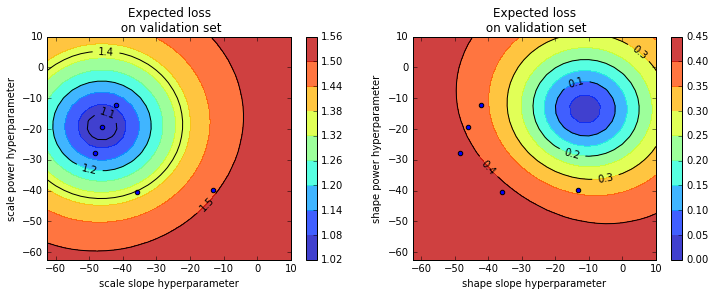

In [21]:
log_sample_points = np.random.uniform(low=l2_reg_min,high=l2_reg_max,
                                      size=[initial_GP_test_points,hyper_param_dim]).astype(np.float32)
sample_points = np.exp(log_sample_points)


f = FloatProgress(min=0, max=initial_GP_test_points-1)
display(f)
sample_values = []
for i in range(initial_GP_test_points):
    f.value = i
    sample_values += [train_model(l2_reg_strength_val = sample_points[i,:],num_steps=500,learning_rate=.1)]
log_sample_values = np.log(sample_values)

fit_GP(log_sample_points, log_sample_values, verbose = True)
plot_GP_model(log_sample_points,log_sample_values)

Now we use our Gaussian process model to decide at which choice of hyper-parameters we should next sample the validation-cross-entropy error.

More specifically, we are trying to find the point $x_{test}$ which maximizes the expected improvement $a_{EI}(x_{test})$ for our model, and then sample the validation-cross-entropy-error at that point.

Since gradient descent is relatively cheap to do in batches, we introduce $n=$ ```max_feelers``` seperate variables, and pack them into an array ```GP_test_points```, and run gradient descent to minimize the (logarithm) of ```GP_expected_improv```. We then choose the best result for $x_{new}$.

In [22]:
with tf.variable_scope('GP-test-point-finder'):
    test_point_list=[]
    for i in range(max_feelers):
        test_point_list += [tf.Variable(tf.random_uniform([hyper_param_dim],l2_reg_min,l2_reg_max))]
    # our test point is randomly initialized
    GP_test_points = tf.pack(test_point_list)
    # For the kernel we stop gradients from back-propagating to the length scale and noise estimates.
    GP_fixed_kernel = lambda l2x,l2y:matern_kernel(l2x,l2y,
                                                     tf.stop_gradient(GP_log_length_scale),
                                                     tf.stop_gradient(GP_log_sample_noise),
                                                    tf.stop_gradient(GP_log_kernel_scale))
    GP_test_point_losses = -GP_expected_improv(GP_fixed_kernel,
                       GP_sampled_x,GP_sampled_y,GP_test_points)
    GP_test_point_optimizer = tf.train.AdamOptimizer(.1)
    GP_test_point_train = GP_optimizer.minimize(tf.reduce_mean(GP_test_point_losses))

Ok, let's iteratively find the test point which maximizes the probability of improvement $a_{PI}(x_{test})$ for our model, and then update our model.

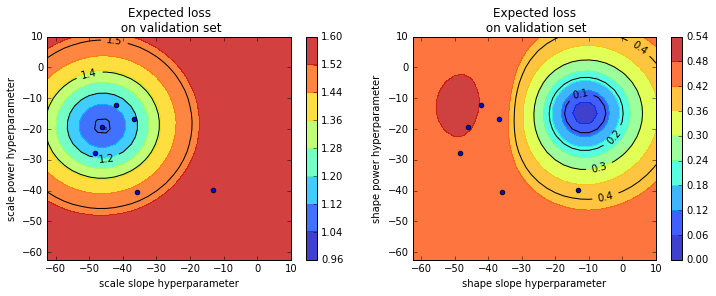

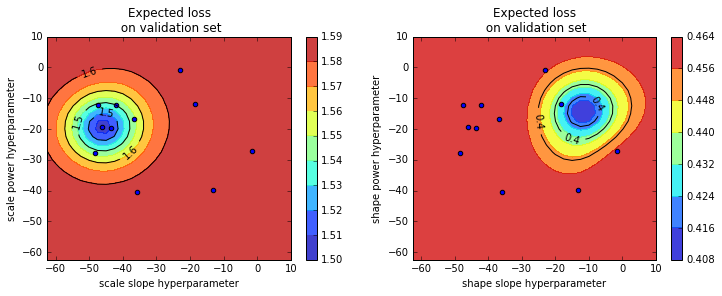

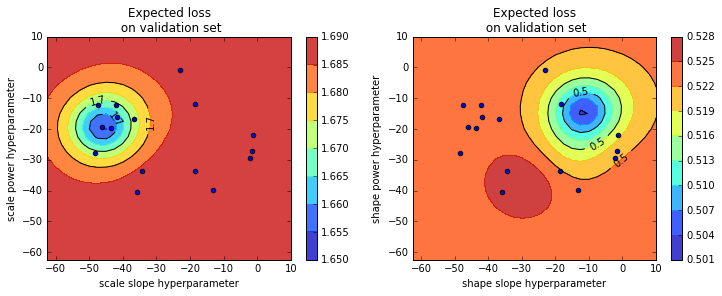

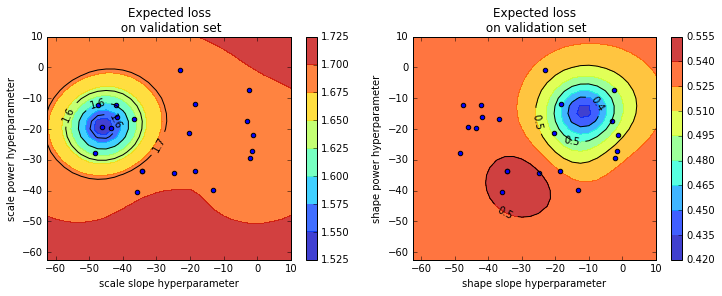

In [23]:
def find_test_point():
    model_variables = tf.get_collection(tf.GraphKeys.VARIABLES, scope='GP-test-point-finder')
    tf.initialize_variables(model_variables).run()
    # optimize the probability of improvement:
    for j in range(100):
        cur_points, losses, _ = sess.run([GP_test_points,GP_test_point_losses,GP_test_point_train],
                           {GP_sampled_x:log_sample_points,
                           GP_sampled_y:log_sample_values})
        for i in range(max_feelers):
            if not np.isfinite(cur_points[i]).all():
                print('resetting feeler')
                tf.initialize_variables([test_point_list[i]]).run()
    min_index = np.argmin(losses)
    return cur_points[min_index,:]

new_tests = total_GP_test_points - initial_GP_test_points+1
f = FloatProgress(min=0, max=new_tests-1)
display(f)
for i in range(new_tests):
    f.value = i
    test_point = find_test_point()
    # print("%d'th test at: (%.3f,%.3f)"%(i,test_point[0],test_point[1]))
    if np.isfinite(test_point).all():
        # add the test point to our list of sampled points
        log_sample_points = np.append(log_sample_points,[test_point],axis = 0)
        sample_points = np.append(sample_points,[np.exp(log_sample_points[-1,:])],axis = 0)
        # estimate the validation-cross-entropy error at the new test point
        sample_values = np.append(sample_values,
                                  [train_model(l2_reg_strength_val = sample_points[-1,:],
                                               num_steps=500,learning_rate=.1)],
                                 axis = 0)
        log_sample_values = np.append(log_sample_values,[np.log(sample_values[-1])],axis=0)
    else:
        print('not finite')
    # Fit the Gaussian process model (after every 5 new test points)
    if i % 5 == 0:
        fit_GP(log_sample_points, log_sample_values)
    # display the results (every 20 new points)
    if i % 5 == 0:
        plot_GP_model(log_sample_points,log_sample_values)
    

Let's find the best values of the hyper-parameters using the resulting Gaussian process model:

In [24]:
with tf.variable_scope('GP-best-point-finder'):
    best_point_list=[]
    for i in range(max_feelers):
        best_point_list += [tf.Variable(tf.random_uniform([hyper_param_dim],l2_reg_min,l2_reg_max))]
    # our best point is randomly initialized
    GP_best_points = tf.pack(best_point_list)
    # For the kernel we stop gradients from back-propagating to the length scale and noise estimates.
    GP_fixed_kernel = lambda l2x,l2y:matern_kernel(l2x,l2y,
                                                     tf.stop_gradient(GP_log_length_scale),
                                                     tf.stop_gradient(GP_log_sample_noise),
                                                    tf.stop_gradient(GP_log_kernel_scale))
    GP_best_point_means = GP_mean(GP_fixed_kernel,
                       GP_sampled_x,GP_sampled_y,GP_best_points)
    GP_best_point_optimizer = tf.train.AdamOptimizer(.05)
    GP_best_point_train = GP_optimizer.minimize(tf.reduce_mean(GP_best_point_means))
    
model_variables = tf.get_collection(tf.GraphKeys.VARIABLES, scope='GP-best-point-finder')
tf.initialize_variables(model_variables).run()
# find the value of best_point which minimizes the Gaussian process:
for j in range(1000):
    cur_points,means,_ = sess.run([GP_best_points,GP_best_point_means,GP_best_point_train],
                    {GP_sampled_x:log_sample_points,
                    GP_sampled_y:log_sample_values})
#     if j % 100 == 0:
#         print(GP_best_point.eval())  
    for i in range(max_feelers):
        if not np.isfinite(cur_points[i]).all():
            print('resetting feeler')
            tf.initialize_variables([best_point_list[i]]).run()
min_index = np.argmin(means)
best_point = cur_points[min_index,:]

In [25]:
GP_min_point_est = np.exp(best_point)
GP_min_value_est = tf.exp(GP_mean_func).eval({GP_sampled_x:log_sample_points,
                           GP_sampled_y:log_sample_values,
                            GP_new_x:[best_point]})
GP_min_error_est = GP_min_value_est*tf.sqrt(tf.reduce_mean(GP_cov_func)).eval({GP_sampled_x:log_sample_points,
                           GP_sampled_y:log_sample_values,
                            GP_new_x:[best_point]})
print("Expected minimum validation-cross entropy: %.4f +- %.4f" %(GP_min_value_est,GP_min_error_est))
print("At point: (%.4f,%.4f,%.4f,%.4f)"%(best_point[0],best_point[1],best_point[2],best_point[3]))
print("Corresponding to hyperparameters:\n\
        prior confidence of constant scale: %.4f,\n\
        prior confidence of scale growing linearly: %.4f,\n\
        prior confidence of constant shape: %.4f,\n\
        prior confidence of shape decreasing inverse-linearly: %.4f"\
      %(np.sqrt(GP_min_point_est[0]),
        np.sqrt(GP_min_point_est[1]),
        np.sqrt(GP_min_point_est[2]),
        np.sqrt(GP_min_point_est[3])))

Expected minimum validation-cross entropy: 1.5350 +- 0.2974
At point: (-45.9120,-19.2220,-11.5458,-14.3572)
Corresponding to hyperparameters:
        prior confidence of constant scale: 0.0000,
        prior confidence of scale growing linearly: 0.0001,
        prior confidence of constant shape: 0.0031,
        prior confidence of shape decreasing inverse-linearly: 0.0008


Now we train our model with these optimal hyper-parameters:

In [26]:
train_model(l2_reg_strength_val=GP_min_point_est,verbose=True)

step: 0, loss: 3.313, a: 0.0500, b: 0.0500, min scale: 0.9512, scale rate of change: 0.9500, 
                      min shape: 1.0513 shape rate of change: 0.95
step: 100, loss: 1.577, a: 0.5240, b: 1.0187, min scale: 0.0854, scale rate of change: 0.8042, 
                      min shape: 2.2956 shape rate of change: 0.67
step: 200, loss: 1.551, a: 0.5281, b: 1.0129, min scale: 0.0873, scale rate of change: 1.1699, 
                      min shape: 5.0913 shape rate of change: 1.05
step: 300, loss: 1.544, a: 0.5289, b: 1.0125, min scale: 0.0848, scale rate of change: 1.3708, 
                      min shape: 8.3790 shape rate of change: 1.37
step: 400, loss: 1.542, a: 0.5294, b: 1.0130, min scale: 0.0817, scale rate of change: 1.5229, 
                      min shape: 11.5384 shape rate of change: 1.67
step: 500, loss: 1.540, a: 0.5296, b: 1.0136, min scale: 0.0789, scale rate of change: 1.6488, 
                      min shape: 14.4050 shape rate of change: 1.96
step: 600, loss: 1.540

1.8451136

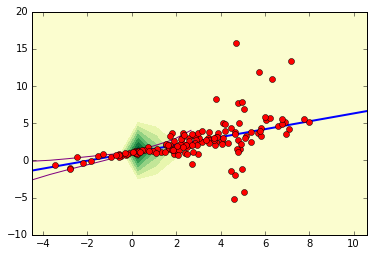

In [27]:
plot_model(ylim=[-10,20])

Finally, we verify the error on our test-set:

In [28]:
test_set_cross_entropy = cross_entropy.eval({x:test_data[:,0],y_:test_data[:,1]})
print("Test Set Cross Entropy Error: %.4f"%test_set_cross_entropy)

Test Set Cross Entropy Error: 1.2476
